In [4]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import tools
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
def Shell(step, R, r, mesh='cube', ORIENTATION=1):
    def condition(xi,yi,zi):
        above_R = (xi**2+yi**2+zi**2 <= (R+0.1)**2)
        below_r = (xi**2+yi**2+zi**2 <= (r+0.1)**2)
        return np.logical_and(above_R, below_r)
    
    R_eff = R+r
    xrange = (-2*int(R_eff), 2*int(R_eff)+1)
    yrange = (-2*int(R_eff), 2*int(R_eff)+1)
    zrange = (-2*int(R_eff), 2*int(R_eff)+1)
    if mesh == 'cube':
        sp = structures._meshCubic(xrange, yrange, zrange, condition)
    elif mesh == 'hex':
        sp = structures._meshHexagonalCompact(xrange, yrange, zrange, condition, ORIENTATION)
    
    sp = np.array(sp, dtype=np.float32).T*step
    sp[2] -= np.min(sp[2])  # shift so that bottom at z=0
    sp[2] += step/2         # shift so that bottom at z=step/2
    dipoles = sp.T
    
    return dipoles

In [11]:
target_radius = 10 # in nm
step = 0.5 # in nm
sphere = structures.sphere(step,
                           R=target_radius/step,
                           mesh='hex') 

shell_thickness = 2 # in nm
shell = Shell(step, R= target_radius/step, r=shell_thickness/step, mesh='hex') 

gold = materials.gold()
peptide = materials.dummy(n=1.5)
struct = structures.struct(step, [sphere, shell], [gold, peptide])

field_generator = fields.plane_wave
wavelengths = np.linspace(400, 900, 51)
field_kwargs = dict(theta=[0], inc_angle=180)

efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=field_kwargs)
n1 = n2 = 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)
sim = core.simulation(struct, efield, dyads)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [10]:
shell.shape, sphere.shape

((57, 3), (48859, 3))

In [ ]:
## --- run the simulation
sim.scatter()

timing for wl=400.00nm - setup: EE 2328.6ms, inv.: 498.1ms, repropa.: 433.4ms (1 field configs), tot: 3260.6ms
timing for wl=410.00nm - setup: EE 55.4ms, inv.: 504.8ms, repropa.: 44.3ms (1 field configs), tot: 604.8ms
timing for wl=420.00nm - setup: EE 78.1ms, inv.: 484.2ms, repropa.: 33.5ms (1 field configs), tot: 596.0ms
timing for wl=430.00nm - setup: EE 98.4ms, inv.: 561.3ms, repropa.: 47.0ms (1 field configs), tot: 707.0ms
timing for wl=440.00nm - setup: EE 84.2ms, inv.: 615.5ms, repropa.: 37.2ms (1 field configs), tot: 737.5ms
timing for wl=450.00nm - setup: EE 104.6ms, inv.: 567.3ms, repropa.: 33.6ms (1 field configs), tot: 705.9ms
timing for wl=460.00nm - setup: EE 88.3ms, inv.: 542.2ms, repropa.: 30.2ms (1 field configs), tot: 661.0ms
timing for wl=470.00nm - setup: EE 95.4ms, inv.: 516.1ms, repropa.: 40.5ms (1 field configs), tot: 652.2ms
timing for wl=480.00nm - setup: EE 86.2ms, inv.: 513.2ms, repropa.: 36.8ms (1 field configs), tot: 636.5ms
timing for wl=490.00nm - setup: 

1

In [ ]:
field_kwargs = tools.get_possible_field_params_spectra(sim)
for i, conf in enumerate(field_kwargs):
    print("config", i, ":", conf)

config 0 : {'inc_angle': 180, 'theta': 0}


In [ ]:
wl, spectrum = tools.calculate_spectrum(sim, field_kwargs[0], linear.extinct)
area_geom = tools.get_geometric_cross_section(sim)

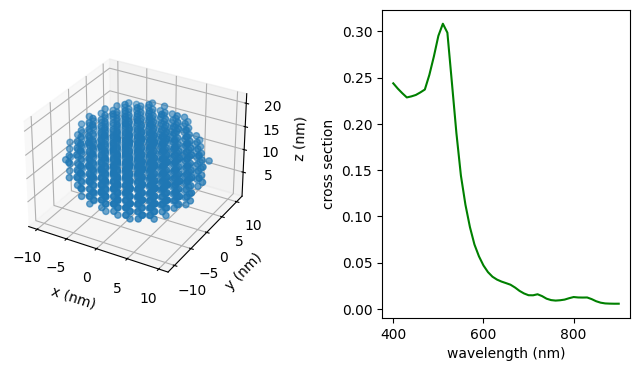

In [ ]:
fig = plt.figure(figsize=(4*2, 4))
fig.subplots_adjust(wspace=0.5)
ax = fig.add_subplot(1,2,1, projection="3d")

ax.scatter(geometry[:,0], geometry[:,1], geometry[:,2])
ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.set_zlabel("z (nm)")

ax = fig.add_subplot(1,2,2)
ax.plot(wl, spectrum.T[0]/area_geom, 'g-', label='ext.')
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel("cross section")

plt.show()

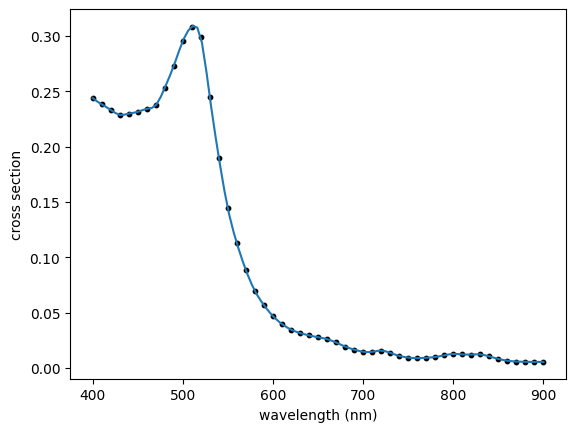

In [ ]:
from scipy.interpolate import splev, splrep

y = spectrum.T[0]/area_geom
spline = splrep(wl, y)
xt = np.linspace(400, 900, 100) # upsample to 100 points
yt = splev(xt, spline)

fig, ax = plt.subplots()
ax.scatter(wl, y, s=10, color='k')
ax.plot(xt, yt)
ax.set_xlabel("wavelength (nm)")
ax.set_ylabel("cross section")
plt.show()

In [ ]:
np.savez("./data/target_sphere.npz", y=yt, x=xt)